In [88]:
%matplotlib inline

import pandas as pd
from Bio import pairwise2
import seaborn
import matplotlib.pyplot as plt
import os

In [52]:
# TODO: merge D1 and D2
Dsegments = {"D1": "GAAATAGT", 
             "D2": "CCTTCCTAC", 
             "D3": "ACTGGGGGATACG", 
             "D2D3": "CCTTCCTACACTGGGGGATACG"}
filepath = "./data/britain/vdj.10_TRD_full.txt"
df = pd.read_csv(filepath, sep = "\t")
df.head()

,#count,freq,cdr3nt,cdr3aa,v,d,j,VEnd,DStart,DEnd,JStart
0,123727,0.486201,TGTGCCTGCCGATTTGGGTACTGGGGGTCCACCGATAAACTCATCTTT,CACRFGYWGSTDKLIF,TRDV2,TRDD3,TRDJ1,7,19,26,29
1,45214,0.177674,TGTGCTCTTGGGGAACGTTCCCTTCCTGCCAAACGATATGGGGTGC...,CALGERSLPAKRYGVLGISLPYTDKLIF,TRDV1,TRDD3,TRDJ1,15,47,53,64
2,23672,0.093022,TGTGCCTCCCTAGGCCTTCCTACGGGGCTGGGGGAAAAACTCATCTTT,CASLGLPTGLGEKLIF,TRDV2,TRDD2,TRDJ1,6,14,22,33
3,19940,0.078357,TGTGCTCTTGGGGAGAGCCCCTGGAGGTCAAACTGTGTATTAAAAA...,CALGESPWRSNCVLKTTHLTAQLFF,TRDV1,.,TRDJ2,13,-1,-1,53
4,18225,0.071617,TGTGCTCTTGGGGAACGGAGAGGGTACTGGGGTCCCACCGATAAAC...,CALGERRGYWGPTDKLIF,TRDV1,TRDD3,TRDJ1,15,25,31,35


In [112]:
# TODO: merge D1 and D2
Dsegments = {"D1": "GAAATAGT", 
             "D2": "CCTTCCTAC", 
             "D3": "ACTGGGGGATACG", 
             "D2D3": "CCTTCCTACACTGGGGGATACG"}
filepath = "./data/britain/vdj.10_TRD_full.txt"
filepath = "./data/holland//donor11.raw.cdrblast.txt"
df = pd.read_csv(filepath, sep = "\t")


def cut_ends(a):
    res = ""
    for i in range(len(a[0])):
        if a[0][i] == a[1][i]:
            res += a[1][i]
        elif a[1][i] == "-":
            res += "-"
        else:
            res += "*"
    return (a[0], res, a[2], a[3])


def pretty(a):
    print(a[0])
    print(a[1])
    

def get_all_alignments(seq, Dsegments, min_len):
    
    def get_start_end_len(a):
        start = -1
        end = -1
        
        max_start, max_end, max_len = -1, -1, -1
        for i in range(0, len(a[0])):
            if a[0][i] == "-" or a[1][i] == "-":
                if end - start + 1 > max_len:
                    max_start = start
                    max_end = end
                    max_len = end - start + 1
                start = -1
                end = -1
            else:
                if a[0][i] == a[1][i]:
                    if start == -1:
                        start = i
                    end = i
                else:
                    if end - start + 1 > max_len:
                        max_start = start
                        max_end = end
                        max_len = end - start + 1

                    start = -1
                    end = -1
        
        return max_start, max_end, max_len
    
    D_alignments = []
    for D_name, D in Dsegments.items():
        a = pairwise2.align.globalxs(seq, D, -3, -3, penalize_end_gaps = False)[0]
        cur_start, cur_end, cur_len = get_start_end_len(a)
#         pretty(cut_ends(a))
#         print(cur_start, cur_end, cur_len)
        D_alignments.append((cur_start, cur_end, cur_len, D_name))
            
    D_alignments = sorted(D_alignments, reverse = True, key = lambda x: x[3])
    D_alignments = sorted(D_alignments, reverse = True, key = lambda x: len(x[3]))
    D_alignments = sorted(D_alignments, reverse = True, key = lambda x: x[2])
    return list(filter(lambda x: x[2] >= min_len, D_alignments))


def find_the_longest(seq, start, end, Dsegments, min_len):
    if end - start > min_len - 1:
        res = get_all_alignments(seq[start:end], Dsegments, min_len)
        print("Alignment:\t", res)
        # if the best score is D2D3,
        # check if D2D3 score better than D2 or D3
        if res:
            if res[0][3] == "D2D3":
                if res[0][2] > res[1][2]:
                    # if so then this is true D2D3 without N alignment
                    return [res[0]]
                else:
                    # otherwise it's just one of the D2, D3 or D2-N-D3 alignment
                    # so just pop it
                    res.pop(0)

            if res:
                # if the best score isn't D2D3,
                # then check for dual alignments
                return sorted((filter(lambda x: x[2] == res[0][2], res)), key = lambda x: x[0])

    return []


def align_df(df, Dsegments, min_len):
    df["D.new"] = "NA"
    df["D5.new1"] = -1
    df["D3.new1"] = -1
    df["D5.new2"] = -1
    df["D3.new2"] = -1
    for i in range(1793, 1795):
        alg = find_the_longest(df["cdr3nt"][i], df["VEnd"][i] + 1, df["JStart"][i], Dsegments, min_len)
        if alg:
            df.loc[i, "D.new"] = ""
            for j, a in enumerate(alg):
                df.loc[i, "D5.new" + str(j+1)] = a[0]
                df.loc[i, "D3.new" + str(j+1)] = a[1]
                df.loc[i, "D.new"] += ("," if j != 0 else "") + a[3]

align_df(df, Dsegments, 3)

Alignment:	 [(6, 8, 3, 'D2D3')]


IndexError: list index out of range

./data/holland//donor11.raw.cdrblast.txt


IndexError: list index out of range

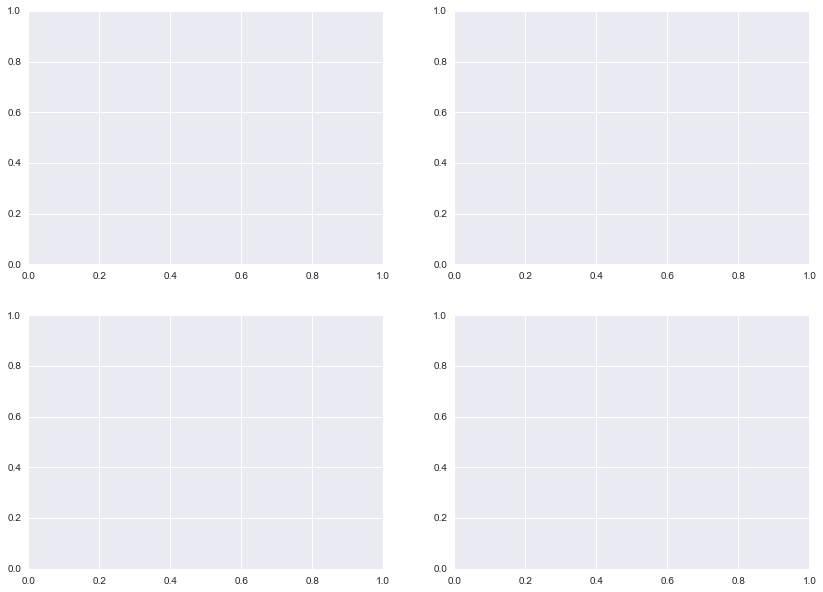

In [98]:
# seaborn.factorplot(x = "D.new", data = df, kind="count", size=6)
folder_path = "./data/britain/"
folder_path = "./data/holland/"
files = [folder_path + "/" + x for x in os.listdir(folder_path)][:2]
f, axes = plt.subplots(len(files) // 2 + 1, 2, figsize=(14, 10))
for i, file in enumerate(files):
    df = pd.read_csv(file, sep = "\t")
    align_df(df, Dsegments, 3)
    axes[i // 2][i % 2].set_ylabel(file)

In [93]:
seq1 = "TGTGCTTTT"
seq2 = "GTGTGGGGAGA"
a = pairwise2.align.localms(seq1, seq2, 2, -1, -3, -3, penalize_end_gaps = False)[0]
pretty(cut_ends(a))
print(a[2:])
    
if ():
    print("!")
    
df["newcol"] = 1
df

5 // 2

-TGTGCTTTT-
*TGTG******
(8.0, 1, 5)


2